# Dogs vs Cats Image Classification

In this notebook, we'll explore some options to implement a model able to classify images of cats and dogs

In [2]:
import os
import random as rd
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt

2022-03-19 00:10:40.318265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-19 00:10:40.318286: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Basic initialization
rd.seed(9)
tf.random.set_seed(9)

CAT_AND_DOGS_DATA_URL: str = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
BATCH_SIZE: int = 32
IMAGE_SHAPE: int = 224

## Data loading

To build our image classifier, we begin by downloading the dataset. The dataset we are using is a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> dataset from Kaggle (ultimately, this dataset is provided by Microsoft Research).

In [4]:
data_folder_name: str = "cats_and_dogs_filtered"
zip_dir: str = tf.keras.utils.get_file(
    fname=f"{data_folder_name}.zip",
    origin=CAT_AND_DOGS_DATA_URL,
    extract=True # Extract the content from the zip file in the .keras folder
)

data_folder_path: str = f"{os.getcwd()}/{data_folder_name}"
# Check if the data already exists in the current directory
if not os.path.isdir(data_folder_path):
    # Copy the data from the .keras folder to the current folder
    shutil.copytree(src=f"{os.path.dirname(zip_dir)}/{data_folder_name}", dst=f"{os.getcwd()}/{data_folder_name}")

train_dir: str = f"{data_folder_path}/train"
train_dog_dir: str = f"{train_dir}/dogs"
train_cat_dir: str = f"{train_dir}/cats"

validation_dir: str = f"{data_folder_path}/validation"
validation_dog_dir: str = f"{validation_dir}/dogs"
validation_cat_dir: str = f"{validation_dir}/cats"

print(f"Number of training images for dogs: {len(os.listdir(train_dog_dir))}")
print(f"Number of training images for cats: {len(os.listdir(train_cat_dir))}")
print(f"Number of validation images for dogs: {len(os.listdir(validation_dog_dir))}")
print(f"Number of validation images for cats: {len(os.listdir(validation_cat_dir))}")

Number of training images for dogs: 1000
Number of training images for cats: 1000
Number of validation images for dogs: 250
Number of validation images for cats: 250


The data provided in the dataset only have the train and validation datasets, but not the test one. To solve this, we'll split the validation set to create a test set.

In [5]:
nb_test_dog_images: int = int(len(os.listdir(validation_dog_dir))/2)
nb_test_cat_images: int = int(len(os.listdir(validation_cat_dir))/2)

test_dir: str = f"{os.getcwd()}/{data_folder_name}/test"
test_dog_dir: str = f"{test_dir}/dogs"
test_cat_dir: str = f"{test_dir}/cats"
# Check if the test directory already exists
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)

    # Pick random files from the validation set to move to the test set
    os.mkdir(test_dog_dir)
    for i in range(nb_test_dog_images):
        shutil.move(src=f"{validation_dog_dir}/{rd.choice(os.listdir(validation_dog_dir))}", dst=test_dog_dir)
    os.mkdir(test_cat_dir)
    for i in range(nb_test_cat_images):
        shutil.move(src=f"{validation_cat_dir}/{rd.choice(os.listdir(validation_cat_dir))}", dst=test_cat_dir)

print(f"Number of training images for dogs: {len(os.listdir(train_dog_dir))}")
print(f"Number of training images for cats: {len(os.listdir(train_cat_dir))}")
print(f"Number of validation images for dogs: {len(os.listdir(validation_dog_dir))}")
print(f"Number of validation images for cats: {len(os.listdir(validation_cat_dir))}")
print(f"Number of test images for dogs: {len(os.listdir(test_dog_dir))}")
print(f"Number of test images for cats: {len(os.listdir(test_cat_dir))}")

Number of training images for dogs: 1000
Number of training images for cats: 1000
Number of validation images for dogs: 250
Number of validation images for cats: 250
Number of test images for dogs: 250
Number of test images for cats: 250


## Data Preparation

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [6]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode="nearest" # Points outside the boundaries of the input are filled according to the given mode
)
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0
)
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0
)

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk, apply rescaling, and resize them using single line of code.

In [7]:
# The labels will be 1D binary labels, since we just have two classes (one per directory)
class_mode: str = "binary"

train_data =  train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode=class_mode,
)
validation_data = validation_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=validation_dir,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode=class_mode,
)
test_data = test_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=test_dir,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode=class_mode,
)

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### Visualize the images

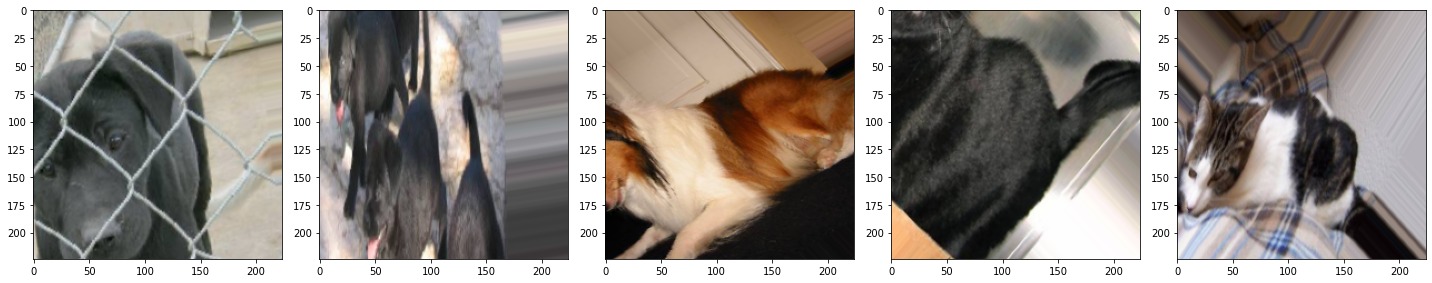

In [9]:
# Get a full batch of images from the train dataset
sample_training_images, _ = next(train_data)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
axes = axes.flatten()
for image, ax in zip(sample_training_images[:5], axes):
    ax.imshow(image)
plt.tight_layout()
plt.show()